<a href="https://colab.research.google.com/github/ockayy/forecasting-Budget/blob/main/Budget_forecasting3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, r2_score
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
import joblib

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## **Data Preparation**

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import joblib  # Import joblib for saving the encoder and scalers

# Load the normalized dataset
df = pd.read_csv('dataset-cap.csv')

# Extract timestamp features (e.g., month and day of the week)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Identify categorical columns
categorical_columns = ['month', 'day_of_week']  # Added month and day_of_week

# One-Hot Encoding the categorical columns
encoder = OneHotEncoder(sparse_output=False)
encoded_categories = encoder.fit_transform(df[categorical_columns])

# Save the fitted encoder to a file for later use
joblib.dump(encoder, 'encoder.pkl')  # Save the encoder instance

# Drop original categorical columns and add encoded categories
df = df.drop(categorical_columns + ['timestamp'], axis=1)  # Dropping original categorical columns and timestamp
df_encoded = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_columns))
df = pd.concat([df, df_encoded], axis=1)

# Feature selection (Now including the one-hot encoded columns)
# Select all numerical features plus the encoded categorical features
features = df[['monthly_income', 'saving_goal', 'inflation_rate', 'cumulative_spend']]  # Excluding 'timestamp' as it's now encoded
features = pd.concat([features, df_encoded], axis=1)

# Normalize features using MinMaxScaler
scaler_features = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)

# Save the fitted feature scaler
joblib.dump(scaler_features, 'scaler_features.pkl')  # Save feature scaler

# Convert the normalized features back to a DataFrame
features_normalized = pd.DataFrame(features_normalized, columns=features.columns)

# Multiple target selection (Predicting daily spending and saving achieved)
targets = df[['daily_spending', 'saving_achieved']]

# Normalize targets using MinMaxScaler
scaler_targets = MinMaxScaler()
targets_normalized = scaler_targets.fit_transform(targets)

# Save the fitted target scaler
joblib.dump(scaler_targets, 'scaler_targets.pkl')  # Save target scaler

# Convert the normalized targets back to a DataFrame
targets_normalized = pd.DataFrame(targets_normalized, columns=targets.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, targets_normalized, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and add a sequence dimension
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1).to(device)  # Add sequence dimension
X_test = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1).to(device)    # Add sequence dimension
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Example for denormalization (if needed later)
y_pred_normalized = torch.tensor([[0.5, 0.6]], dtype=torch.float32)  # Example normalized prediction tensor
y_pred_normalized = y_pred_normalized.cpu().numpy()  # Convert to numpy for scaler usage
y_pred_original = scaler_targets.inverse_transform(y_pred_normalized)

print(f"Denormalized prediction: {y_pred_original}")


Denormalized prediction: [[ 5329.199 25822.666]]


# **LSTM MODEL**

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example modification with ReLU for non-negative outputs:
class LSTMModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LSTMModelWithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()  # Adding ReLU activation to ensure non-negative output

    def forward(self, x):
        # Initialize hidden state with zeros
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Initialize cell state with zeros
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out[:, -1, :])  # Apply dropout after getting output from LSTM
        out = self.fc(out)
        out = self.relu(out)  # Apply ReLU to ensure non-negative outputs
        return out

# Parameters
input_size = X_train.size(2)  # Automatically set based on the number of input features
hidden_size = 400  # Same as before 350-400-800
num_layers = 6    # Same as before 4 - 5 - 6
output_size = 2   # Assuming two output values: 'daily_spending' and 'saving_achieved'
dropout_prob = 0.3  # Introduce dropout with 50% probability
num_epochs = 200 #100-200
batch_size = 64

# Initialize the model with dropout
model = LSTMModelWithDropout(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
criterion = nn.MSELoss()  # Example loss function, adjust as needed
optimizer = optim.Adam(model.parameters(), lr=0.0003)  # Keep the learning rate the same

# Training Loop with Dropout
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/200], Loss: 0.0923
Epoch [20/200], Loss: 0.0922
Epoch [30/200], Loss: 0.0922
Epoch [40/200], Loss: 0.0921
Epoch [50/200], Loss: 0.0920
Epoch [60/200], Loss: 0.0894
Epoch [70/200], Loss: 0.0829
Epoch [80/200], Loss: 0.0210
Epoch [90/200], Loss: 0.0185
Epoch [100/200], Loss: 0.0160
Epoch [110/200], Loss: 0.0156
Epoch [120/200], Loss: 0.0152
Epoch [130/200], Loss: 0.0150
Epoch [140/200], Loss: 0.0148
Epoch [150/200], Loss: 0.0148
Epoch [160/200], Loss: 0.0146
Epoch [170/200], Loss: 0.0145
Epoch [180/200], Loss: 0.0146
Epoch [190/200], Loss: 0.0144
Epoch [200/200], Loss: 0.0143


Test MSE Loss after introducing dropout: 0.0149
Test MAE Loss after introducing dropout: 0.0730
R2 Score: 0.6443


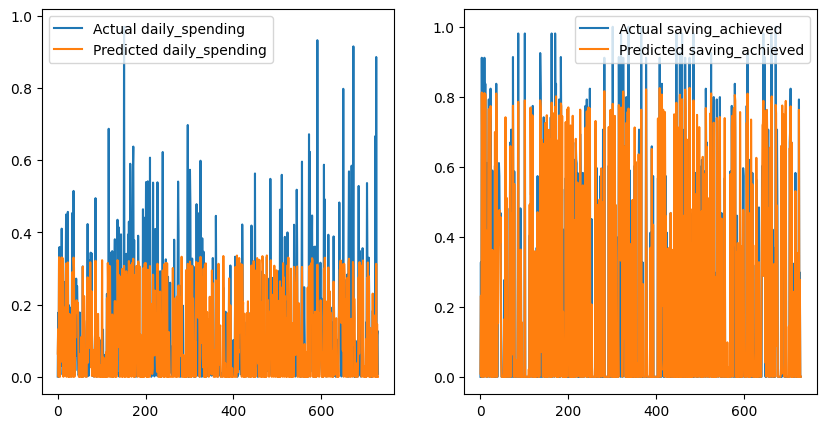

In [69]:
# Evaluate on test data with dropout
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    test_loss = criterion(outputs, y_test)  # MSE Loss

    # Calculate additional metrics
    actual_values = y_test.cpu().numpy()
    predicted_values = outputs.cpu().numpy()

    mae_loss = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    print(f'Test MSE Loss after introducing dropout: {test_loss.item():.4f}')
    print(f'Test MAE Loss after introducing dropout: {mae_loss:.4f}')
    print(f'R2 Score: {r2:.4f}')

# Plot predictions vs actuals for each target after introducing dropout
plt.figure(figsize=(10, 5))
for i, target_name in enumerate(['daily_spending', 'saving_achieved']):
    plt.subplot(1, 2, i + 1)
    plt.plot(y_test[:, i].cpu().numpy(), label=f'Actual {target_name}')
    plt.plot(outputs[:, i].cpu().numpy(), label=f'Predicted {target_name}')
    plt.legend()
plt.show()


# **Export model**

In [70]:
import torch

# Define the path where you want to save the model
model_save_path = "budgetmodel.pth"

# Save both the model's and optimizer's state_dict
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'dropout_prob': dropout_prob
}, model_save_path)


print(f"Model and optimizer saved to {model_save_path}")


Model and optimizer saved to budgetmodel.pth


# **Testing with Console**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import datetime
import calendar
import os
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import joblib

# Load the saved scalers and encoder to maintain consistency with training
scaler_features = joblib.load('scaler_features.pkl')
scaler_targets = joblib.load('scaler_targets.pkl')
encoder = joblib.load('encoder.pkl')

# Define the LSTM model class (consistent with training)
class LSTMModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LSTMModelWithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return self.relu(out)

# Load the trained model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    input_size = checkpoint['input_size']
    hidden_size = checkpoint['hidden_size']
    num_layers = checkpoint['num_layers']
    output_size = checkpoint['output_size']
    dropout_prob = checkpoint['dropout_prob']
    model = LSTMModelWithDropout(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, dropout_prob=dropout_prob)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print("Model loaded successfully.")
    return model

# Function to predict daily budget range
def predict_daily_budget(model, input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        output = model(input_tensor)
        return output.cpu().numpy()

# Function to denormalize the predicted output
def denormalize_output(predicted_budget):
    predicted_budget_denorm = scaler_targets.inverse_transform(predicted_budget)
    return predicted_budget_denorm

# Function to plot graphs for spending pattern
def plot_suggested_spending_pattern(income, saving_goal, days_in_month, spending_range):
    daily_budget = (income - saving_goal) / days_in_month
    days = np.arange(1, days_in_month + 1)
    spending_pattern = daily_budget * np.ones_like(days)

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Suggested Spending Range: {spending_range[0][0]:.2f} - {spending_range[0][1]:.2f}", fontsize=14)

    # Plot daily spending pattern
    plt.subplot(3, 1, 1)
    plt.plot(days, spending_pattern, 'bo-', label='Daily Spending')
    plt.axhline(y=daily_budget, color='g', linestyle='--', label='Required Daily Spending')
    plt.title('Daily Spending Pattern')
    plt.xlabel('Day of Month')
    plt.ylabel('Amount Spent')
    plt.legend()

    # Plot cumulative spending
    plt.subplot(3, 1, 2)
    cumulative_spending = np.cumsum(spending_pattern)
    plt.plot(days, cumulative_spending, 'go-', label='Cumulative Spending')
    plt.title('Cumulative Spending Over the Month')
    plt.xlabel('Day of Month')
    plt.ylabel('Cumulative Amount Spent')
    plt.legend()

    # Plot remaining balance
    plt.subplot(3, 1, 3)
    remaining_balance = income - cumulative_spending
    plt.plot(days, remaining_balance, 'ro-', label='Remaining Balance')
    plt.axhline(y=saving_goal, color='orange', linestyle='--', label='Desired Savings Goal')
    plt.title('Remaining Balance Over the Month')
    plt.xlabel('Day of Month')
    plt.ylabel('Remaining Balance')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot bar chart for predicted expenses by day of the week
def plot_predicted_expenses(expenses, title):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.figure(figsize=(10, 5))
    plt.bar(days_of_week, expenses, color='blue')
    plt.xlabel('Day of the Week')
    plt.ylabel('Total Predicted Expenses')
    plt.title(title)
    plt.show()

# Main function to handle user inputs and generate outputs
def main():
    print("Welcome to the Financial Model Testing Console.")
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = "budgetmodel.pth"
    model = load_model(model_path)

    monthly_income = float(input("Enter your monthly income: "))
    saving_goal = float(input("Enter your saving goal for this month: "))
    inflation_rate = float(input("Enter the current inflation rate (as a decimal): "))
    today = datetime.date.today()
    days_in_month = calendar.monthrange(today.year, today.month)[1]
    data_available = input("Do you have previous spending data? (yes/no): ").strip().lower()

    cumulative_spend = 0  # Default to zero if no previous data
    num_days = 0
    if data_available == 'yes':
        num_days = int(input(f"How many days of prior data do you have? (Max {today.day}): "))
        expenses = []
        for i in range(num_days):
            expense = float(input(f"Enter amount spent on day {i + 1}: "))
            expenses.append(expense)
        cumulative_spend = sum(expenses)
        remaining_budget = monthly_income - cumulative_spend
        print(f"Cumulative spend for past {num_days} days: {cumulative_spend}")
        print(f"Remaining budget for the month: {remaining_budget}")
    else:
        print("No previous data available. Suggesting a spending pattern...")
        remaining_budget = monthly_income
        cumulative_spend = 0

    # Predict current month's spending pattern
    month = today.month
    day_of_week = today.weekday()

    test_input_df = pd.DataFrame([[month, day_of_week]], columns=encoder.feature_names_in_)
    encoded_test_categories = encoder.transform(test_input_df)
    encoded_test_df = pd.DataFrame(encoded_test_categories, columns=encoder.get_feature_names_out())

    input_data = pd.concat([pd.DataFrame([[monthly_income, saving_goal, cumulative_spend, inflation_rate]], columns=['monthly_income', 'saving_goal', 'cumulative_spend', 'inflation_rate']), encoded_test_df], axis=1)
    expected_columns = scaler_features.feature_names_in_
    input_data = input_data.reindex(columns=expected_columns, fill_value=0)
    input_data_scaled = scaler_features.transform(input_data)

    predictions = predict_daily_budget(model, input_data_scaled[0])
    spending_range = denormalize_output(predictions)

    plot_suggested_spending_pattern(remaining_budget, saving_goal, days_in_month - num_days, spending_range)
    print(f"Suggested daily budget for current month: {spending_range[0][0]:.2f} - {spending_range[0][1]:.2f}")

    # Predict and plot for the next month
    next_month = (today.month % 12) + 1
    next_input_df = pd.DataFrame([[next_month, day_of_week]], columns=encoder.feature_names_in_)
    encoded_next_month_categories = encoder.transform(next_input_df)
    encoded_next_month_df = pd.DataFrame(encoded_next_month_categories, columns=encoder.get_feature_names_out())

    next_input_data = pd.concat([pd.DataFrame([[monthly_income, saving_goal, cumulative_spend, inflation_rate]], columns=['monthly_income', 'saving_goal', 'cumulative_spend', 'inflation_rate']), encoded_next_month_df], axis=1)
    next_input_data = next_input_data.reindex(columns=expected_columns, fill_value=0)
    next_input_data_scaled = scaler_features.transform(next_input_data)

    next_month_predictions = predict_daily_budget(model, next_input_data_scaled[0])
    next_month_spending_range = denormalize_output(next_month_predictions)

    # Plot a bar chart for the next month's predicted expenses by day of the week
    plot_predicted_expenses(next_month_spending_range.flatten(), "Predicted Expenses by Day of the Week for Next Month")

    print(f"Suggested daily budget for next month: {next_month_spending_range[0][0]:.2f} - {next_month_spending_range[0][1]:.2f}")


    # Collect user feedback - Ensure this part is reached
    feedback = input("Do you agree with the suggested budget? (yes/no): ").strip().lower()

    # Save inputs, outputs, and feedback to a CSV file
    feedback_data = {
        'monthly_income': monthly_income,
        'saving_goal': saving_goal,
        'inflation_rate': inflation_rate,
        'cumulative_spend': cumulative_spend,
        'predicted_budget_min': spending_range[0][0],
        'predicted_budget_max': spending_range[0][1],
        'feedback': feedback
    }

    csv_file = 'user_feedback.csv'
    write_header = not os.path.exists(csv_file)
    feedback_df = pd.DataFrame([feedback_data])
    feedback_df.to_csv(csv_file, mode='a', header=write_header, index=False)
    print("Feedback saved to 'user_feedback.csv'.")

# Run the main function
if __name__ == "__main__":
    main()


Welcome to the Financial Model Testing Console.
Model loaded successfully.


KeyboardInterrupt: Interrupted by user

Welcome to the Financial Model Testing Console.
Enter your monthly income: 50000
Enter your saving goal for this month: 10000
Enter cumulative spend till now: 2133
Enter the current inflation rate (as a decimal): 0.022
Daily budget range for next month: 11167.14 - 11566.57


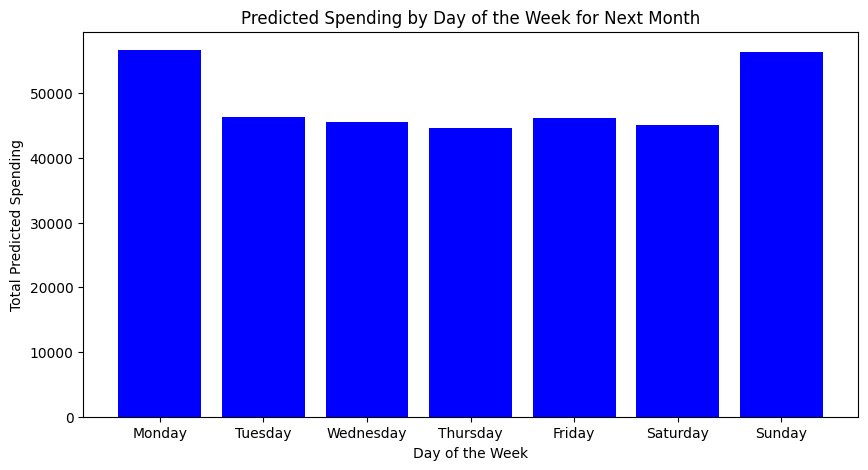

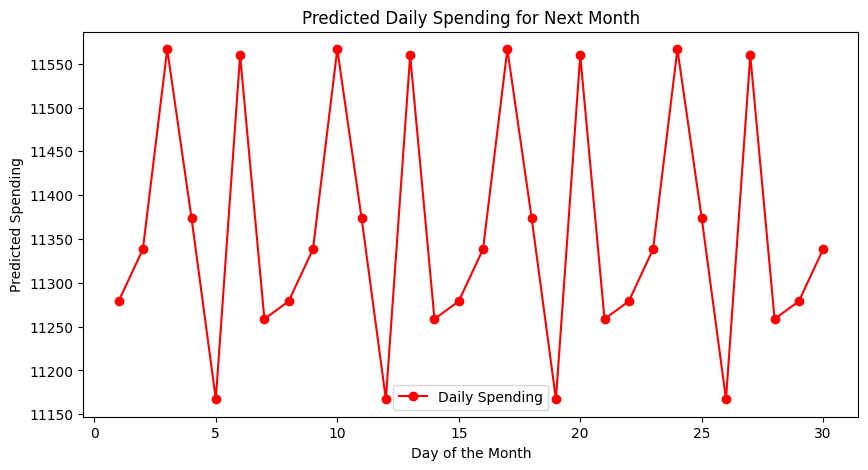

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import datetime
import calendar
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import joblib

# Load the saved scalers and encoder to maintain consistency with training
scaler_features = joblib.load('scaler_features.pkl')
scaler_targets = joblib.load('scaler_targets.pkl')
encoder = joblib.load('encoder.pkl')

# Define the LSTM model class (consistent with training)
class LSTMModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LSTMModelWithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return self.relu(out)

# Load the trained model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    input_size = checkpoint['input_size']
    hidden_size = checkpoint['hidden_size']
    num_layers = checkpoint['num_layers']
    output_size = checkpoint['output_size']
    dropout_prob = checkpoint['dropout_prob']
    model = LSTMModelWithDropout(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, dropout_prob=dropout_prob)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

# Function to predict daily budget range
def predict_daily_budget(model, input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        output = model(input_tensor)
        return output.cpu().numpy()

# Function to denormalize the predicted output
def denormalize_output(predicted_budget):
    predicted_budget_denorm = scaler_targets.inverse_transform(predicted_budget)
    return predicted_budget_denorm

# Function to generate bar graph showing predicted spending by day of the week
def plot_spending_by_day(spending_pattern, title):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    total_spending_by_day = [0] * 7
    for day, amount in spending_pattern.items():
        total_spending_by_day[day] += amount
    plt.figure(figsize=(10, 5))
    plt.bar(days_of_week, total_spending_by_day, color='blue')
    plt.xlabel('Day of the Week')
    plt.ylabel('Total Predicted Spending')
    plt.title(title)
    plt.show()

# Function to generate line graph showing predicted daily spending over the month
def plot_daily_spending(daily_spending, title):
    days = list(range(1, len(daily_spending) + 1))
    amounts = list(daily_spending.values())
    plt.figure(figsize=(10, 5))
    plt.plot(days, amounts, 'ro-', label='Daily Spending')
    plt.xlabel('Day of the Month')
    plt.ylabel('Predicted Spending')
    plt.title(title)
    plt.legend()
    plt.show()

# Main function for test case
def main():
    print("Welcome to the Financial Model Testing Console.")
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = "budgetmodel.pth"
    model = load_model(model_path)

    monthly_income = float(input("Enter your monthly income: "))
    saving_goal = float(input("Enter your saving goal for this month: "))
    cumulative_spend = float(input("Enter cumulative spend till now: "))
    inflation_rate = float(input("Enter the current inflation rate (as a decimal): "))

    # Calculate remaining budget
    remaining_budget = monthly_income - cumulative_spend - saving_goal

    today = datetime.date.today()
    next_month = (today.month % 12) + 1
    year = today.year if next_month != 1 else today.year + 1
    days_in_next_month = calendar.monthrange(year, next_month)[1]

    day_of_week_pattern = {}
    daily_spending_pattern = {}

    # Predict spending pattern for each day of the next month
    for day in range(1, days_in_next_month + 1):
        # Determine the day of the week for the given day
        date = datetime.date(year, next_month, day)
        day_of_week = date.weekday()  # Monday=0, Sunday=6

        test_input_df = pd.DataFrame([[next_month, day_of_week]], columns=encoder.feature_names_in_)
        encoded_test_categories = encoder.transform(test_input_df)
        encoded_test_df = pd.DataFrame(encoded_test_categories, columns=encoder.get_feature_names_out())

        input_data = pd.concat([pd.DataFrame([[monthly_income, saving_goal, remaining_budget, inflation_rate]], columns=['monthly_income', 'saving_goal', 'cumulative_spend', 'inflation_rate']), encoded_test_df], axis=1)
        expected_columns = scaler_features.feature_names_in_
        input_data = input_data.reindex(columns=expected_columns, fill_value=0)
        input_data_scaled = scaler_features.transform(input_data)

        # Predict the spending for this particular day
        predictions = predict_daily_budget(model, input_data_scaled[0])
        spending_range = denormalize_output(predictions)

        # Use the predicted spending range as daily budget range
        predicted_spending = (spending_range[0][0] + spending_range[0][1]) / 2
        daily_spending_pattern[day] = predicted_spending
        day_of_week_pattern[day_of_week] = day_of_week_pattern.get(day_of_week, 0) + predicted_spending

    # Display results
    min_budget = min(daily_spending_pattern.values())
    max_budget = max(daily_spending_pattern.values())
    print(f"Daily budget range for next month: {min_budget:.2f} - {max_budget:.2f}")

    # Plot graphs
    plot_spending_by_day(day_of_week_pattern, "Predicted Spending by Day of the Week for Next Month")
    plot_daily_spending(daily_spending_pattern, "Predicted Daily Spending for Next Month")

# Run the main function
if __name__ == "__main__":
    main()


Welcome to the Financial Model Testing Console.
Model loaded successfully.
Enter your monthly income: 50000
Enter your saving goal for this month: 12000
Enter the current inflation rate (as a decimal): .1110
Enter cumulative spend till now: 2133
Scaled input data: [[ 0.16666667  0.50118158 -1.42509025  0.00642925  0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.          0.        ]]
Raw model predictions: [[0.1363262  0.24631932]]
Predicted values (normalized): [[0.1363262  0.24631932]]
Predicted values (denormalized): [[ 2375.9502 10601.035 ]]
Denormalized spending range: [[ 2375.9502 10601.035 ]]


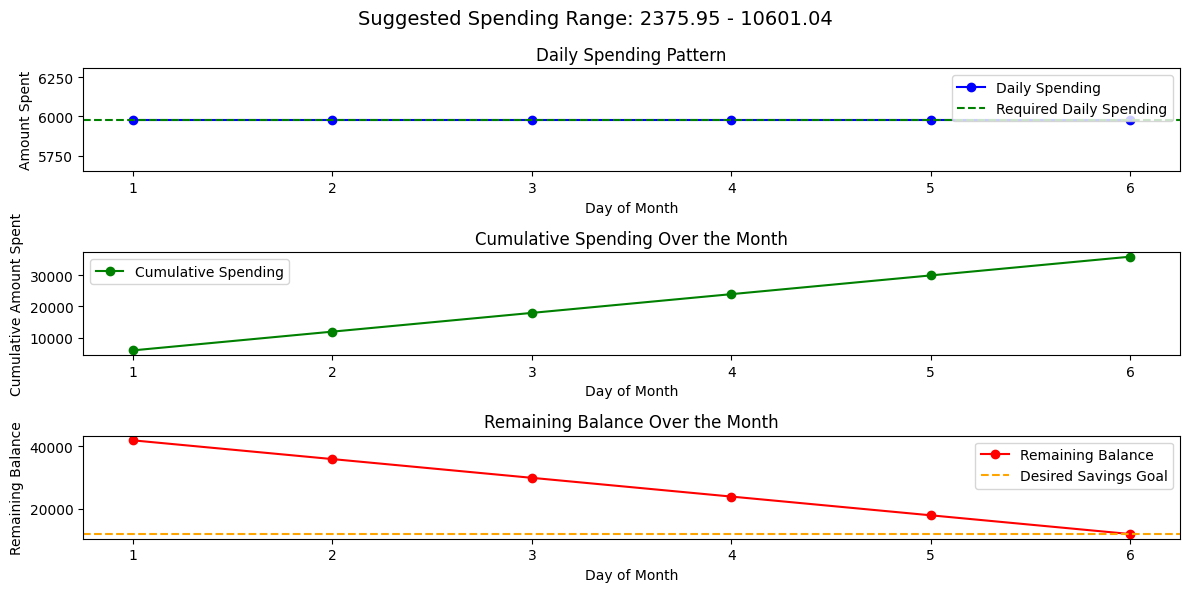

Suggested daily budget: 2375.95 - 10601.04


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import datetime
import calendar
import os
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import joblib

# Load the saved scalers and encoder to maintain consistency with training
scaler_features = joblib.load('scaler_features.pkl')
scaler_targets = joblib.load('scaler_targets.pkl')
encoder = joblib.load('encoder.pkl')

# Define the LSTM model class (consistent with training)
class LSTMModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LSTMModelWithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return self.relu(out)

# Load the trained model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    input_size = checkpoint['input_size']
    hidden_size = checkpoint['hidden_size']
    num_layers = checkpoint['num_layers']
    output_size = checkpoint['output_size']
    dropout_prob = checkpoint['dropout_prob']
    model = LSTMModelWithDropout(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, dropout_prob=dropout_prob)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print("Model loaded successfully.")
    return model

# Function to predict daily budget range
def predict_daily_budget(model, input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        output = model(input_tensor)
        return output.cpu().numpy()

# Function to denormalize the predicted output
def denormalize_output(predicted_budget):
    # Debug: Print the predicted values before denormalization
    print(f"Predicted values (normalized): {predicted_budget}")
    predicted_budget_denorm = scaler_targets.inverse_transform(predicted_budget)
    # Debug: Print the predicted values after denormalization
    print(f"Predicted values (denormalized): {predicted_budget_denorm}")
    return predicted_budget_denorm

# Function to plot graphs without previous data
def plot_suggested_spending_pattern(income, saving_goal, days_in_month, spending_range):
    daily_budget = (income - saving_goal) / days_in_month
    days = np.arange(1, days_in_month + 1)
    spending_pattern = daily_budget * np.ones_like(days)
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Suggested Spending Range: {spending_range[0][0]:.2f} - {spending_range[0][1]:.2f}", fontsize=14)
    plt.subplot(3, 1, 1)
    plt.plot(days, spending_pattern, 'bo-', label='Daily Spending')
    plt.axhline(y=daily_budget, color='g', linestyle='--', label='Required Daily Spending')
    plt.title('Daily Spending Pattern')
    plt.xlabel('Day of Month')
    plt.ylabel('Amount Spent')
    plt.legend()
    plt.subplot(3, 1, 2)
    cumulative_spending = np.cumsum(spending_pattern)
    plt.plot(days, cumulative_spending, 'go-', label='Cumulative Spending')
    plt.title('Cumulative Spending Over the Month')
    plt.xlabel('Day of Month')
    plt.ylabel('Cumulative Amount Spent')
    plt.legend()
    plt.subplot(3, 1, 3)
    remaining_balance = income - cumulative_spending
    plt.plot(days, remaining_balance, 'ro-', label='Remaining Balance')
    plt.axhline(y=saving_goal, color='orange', linestyle='--', label='Desired Savings Goal')
    plt.title('Remaining Balance Over the Month')
    plt.xlabel('Day of Month')
    plt.ylabel('Remaining Balance')
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    print("Welcome to the Financial Model Testing Console.")
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = "budgetmodel.pth"
    model = load_model(model_path)
    monthly_income = float(input("Enter your monthly income: "))
    saving_goal = float(input("Enter your saving goal for this month: "))
    inflation_rate = float(input("Enter the current inflation rate (as a decimal): "))
    today = datetime.date.today()
    days_in_month = calendar.monthrange(today.year, today.month)[1]

    # Assume cumulative spend is entered
    cumulative_spend = float(input("Enter cumulative spend till now: "))
    remaining_budget = monthly_income - cumulative_spend
    num_days = today.day - 1

    # Proceed with prediction for the remaining balance
    month = today.month
    day_of_week = today.weekday()

    # Prepare data for encoding
    test_input_df = pd.DataFrame([[month, day_of_week]], columns=encoder.feature_names_in_)

    # One-hot encode categorical features
    encoded_test_categories = encoder.transform(test_input_df)
    encoded_test_df = pd.DataFrame(encoded_test_categories, columns=encoder.get_feature_names_out())

    # Combine numerical and encoded categorical features
    input_data = pd.concat([pd.DataFrame([[monthly_income, saving_goal, cumulative_spend, inflation_rate]], columns=['monthly_income', 'saving_goal', 'cumulative_spend', 'inflation_rate']), encoded_test_df], axis=1)

    # Reorder columns to match scaler expectations
    expected_columns = scaler_features.feature_names_in_
    input_data = input_data.reindex(columns=expected_columns, fill_value=0)

    # Scale the input data
    input_data_scaled = scaler_features.transform(input_data)
    print("Scaled input data:", input_data_scaled)

    # Model prediction
    predictions = predict_daily_budget(model, input_data_scaled[0])
    print("Raw model predictions:", predictions)

    # Denormalization
    spending_range = denormalize_output(predictions)
    print("Denormalized spending range:", spending_range)

    # Plot and display results
    plot_suggested_spending_pattern(remaining_budget, saving_goal, days_in_month - num_days, spending_range)
    print(f"Suggested daily budget: {spending_range[0][0]:.2f} - {spending_range[0][1]:.2f}")

main()